In [1]:
!pip install meteostat

In [42]:
from meteostat import Point,Daily,Hourly
from datetime import datetime
import pandas as pd
import numpy as np

In [3]:
start = pd.to_datetime("1970-1-1")
end = pd.to_datetime("2024-11-1")

In [4]:
# vancouver = Point(lattitude,longitude,elevation)
vancouver = Point(23.0225,72.5714,70)

In [5]:
df = Daily(vancouver,start,end)
df = df.fetch()

In [6]:
df.ffill(inplace=True)

In [7]:
df.dropna(subset=['tmax','tmin'],inplace=True)

In [8]:
df.isnull().sum()

,0
tavg,0
tmin,0
tmax,0
prcp,0
snow,18928
wdir,15565
wspd,10813
wpgt,18928
pres,15563
tsun,18928


In [9]:
df.reset_index(inplace=True)
df['time'] = pd.to_datetime(df['time'])

In [10]:
data = df.iloc[:,:5]
data.tail()

,time,tavg,tmin,tmax,prcp
18923,2024-10-28,30.1,23.9,38.1,0.0
18924,2024-10-29,30.1,24.9,36.7,0.0
18925,2024-10-30,29.5,22.9,36.5,0.0
18926,2024-10-31,29.8,23.9,37.5,0.0
18927,2024-11-01,28.9,22.9,36.3,0.0


In [11]:
df1 = data.iloc[:,2:4]

In [12]:
df1.head()

,tmin,tmax
0,17.9,27.9
1,13.9,24.9
2,13.9,25.9
3,6.9,27.9
4,11.9,30.9


In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np.array(df1))

In [14]:
len(scaled_data)

18928

In [15]:
train_size = int((0.8)*len(data))
test_size = int((0.2)*len(data))


In [16]:
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [17]:
len(test_data),len(train_data)

(3786, 15142)

In [18]:
X_train = []
y_train = []

timestep = 100

for i in range(timestep,len(train_data)):
    X_train.append(train_data[i-timestep:i])
    y_train.append(train_data[i])

X_train,y_train = np.array(X_train),np.array(y_train)

In [19]:
X_test = []
y_test = []

for i in range(timestep,len(test_data)):
    X_test.append(test_data[i-timestep:i])
    y_test.append(test_data[i])

X_test,y_test = np.array(X_test),np.array(y_test)

In [20]:
X_test.shape,y_test.shape

((3686, 100, 2), (3686, 2))

In [21]:
X_train.shape,y_train.shape

((15042, 100, 2), (15042, 2))

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,LayerNormalization,BatchNormalization,Dropout,Input,GRU,LeakyReLU

In [23]:
from tensorflow.keras.initializers import GlorotNormal,HeNormal
from tensorflow.keras.activations import relu
from tensorflow.keras import layers
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras import activations

initializer = GlorotNormal()
model = Sequential()

model.add(Input(shape =( X_train.shape[1],X_train.shape[2])))

# model.add(LSTM(200,return_sequences=True,))
# model.add(LayerNormalization())

# model.add(LSTM(200,return_sequences=True,kernel_initializer=GlorotNormal))
# model.add(LayerNormalization())

model.add(LSTM(512,))


model.add(Dense(128,))
model.add(layers.Activation(activations.relu))
model.add(BatchNormalization())
model.add(Dropout(0.16))

# model.add(Dense(64,))
# model.add(layers.Activation(activations.selu))
# model.add(BatchNormalization())
model.add(Dense(2))

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 512)                 │       1,054,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121,154 (4.28 MB)

 Trainable params: 1,120,898 (4.28 MB)

 Non-trainable params: 256 (1.00 KB)

In [25]:
model.compile(optimizer='adam',loss='mse',metrics=['mse'])

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

callback = ModelCheckpoint(
    "best_model.keras",
    monitor = 'val_loss',
    mode = 'min',
    save_weights_only = False,
    save_best_only = True,
    verbose = 1
)

In [27]:
history = model.fit(X_train,y_train,epochs = 100,validation_data = (X_test,y_test),callbacks=[callback])

Epoch 1/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0750 - mse: 0.0750
Epoch 1: val_loss improved from inf to 0.02390, saving model to best_model.keras
471/471 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.0749 - mse: 0.0749 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 2/100
470/471 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0051 - mse: 0.0051
Epoch 2: val_loss did not improve from 0.02390
471/471 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 3/100
469/471 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0052 - mse: 0.0052
Epoch 3: val_loss improved from 0.02390 to 0.00264, saving model to best_model.keras
471/471 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/100
470/471 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0047 - mse: 0.0047
Epoch 4: val_loss did not improve from 0.00264
471/471 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0047 - mse: 0.0047 - val_loss

KeyboardInterrupt: 

In [28]:
actual_values = scaler.inverse_transform(y_test)

In [29]:
actual_values

array([[27.8, 34.2],
       [27.8, 34.2],
       [27.8, 34.2],
       ...,
       [22.9, 36.5],
       [23.9, 37.5],
       [22.9, 36.3]])

In [30]:
from tensorflow.keras.models import load_model

model = load_model('best_model.keras')
predicted_values = model.predict(X_test)

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [31]:
predicted_values.shape

(3686, 2)

In [32]:
predicted_values_rescaled = scaler.inverse_transform(predicted_values)

In [33]:
predicted_values_rescaled

array([[27.409754, 34.481506],
       [27.405828, 34.50562 ],
       [27.40246 , 34.525215],
       ...,
       [24.834934, 36.840992],
       [23.457424, 36.521038],
       [24.094688, 37.358234]], dtype=float32)

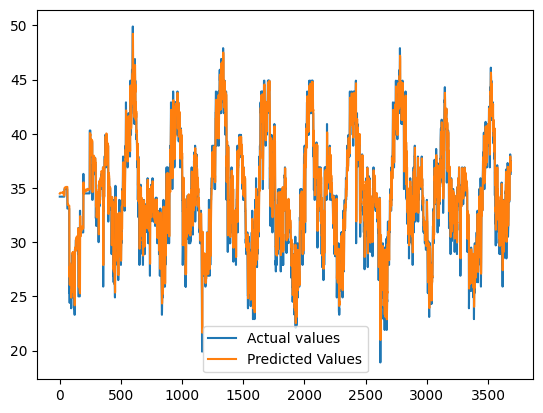

In [34]:
import matplotlib.pyplot as plt

plt.plot(actual_values[:,1],label = "Actual values")
plt.plot(predicted_values_rescaled[:,1],label = "Predicted Values")
plt.legend()

471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


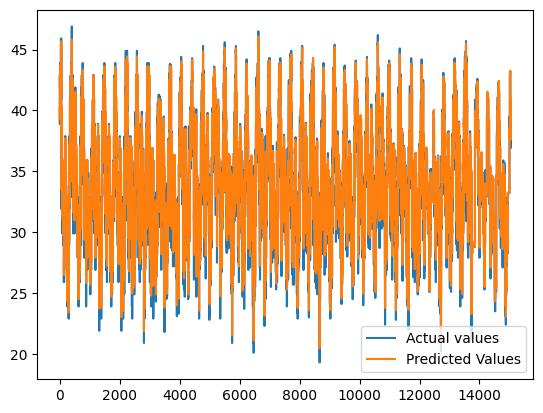

In [35]:
train_data_rescaled = scaler.inverse_transform(y_train)
train_predict = model.predict(X_train)
train_predict_rescaled = scaler.inverse_transform(train_predict)
plt.plot(train_data_rescaled[:,1],label = "Actual values")
plt.plot(train_predict_rescaled[:,1],label = "Predicted Values")
plt.legend()

In [36]:
actual_data = scaler.inverse_transform(scaled_data)

In [37]:
import plotly.graph_objects as go

# Create a figure
figure = go.Figure()

# Define x-axis values (timeline)
x_actual = list(range(len(actual_data)))
x_train = list(range(lookback+105,lookback+ len(train_predict_tmin)))

# Plot actual minimum temperature
figure.add_trace(go.Scatter(
    x=x_actual,
    y=actual_data[:,0],
    mode='lines',
    name='Actual Min Temperature',
    line=dict(color='blue')
))

# Plot predicted minimum temperature for training data
figure.add_trace(go.Scatter(
    x=x_train,
    y=train_predict_tmin[lookback:lookback+len(train_predict_tmin)],
    mode='lines',
    name='Predicted Min Temperature (Train)',
    line=dict(color='green')
))

# Optional: If you also want to include test predictions
x_test = list(range(len(train_predict_rescaled) + 200, len(train_predict_rescaled) + 200 + len(test_predict_tmin)))
figure.add_trace(go.Scatter(
    x=x_test,
    y=test_predict_tmin,
    mode='lines',
    name='Predicted Min Temperature (Test)',
    line=dict(color='orange')
))

# Update layout
figure.update_layout(
    title="Actual vs Predicted Min Temperatures",
    xaxis_title="Time",
    yaxis_title="Temperature",
    legend_title="Legend",
    template="plotly_white",
    width=1400,
    height=600
)

# Show the plot
figure.show()


NameError: name 'lookback' is not defined

In [38]:
input_data = scaled_data[-100:]

predicted_values = []


for i in range(7):

  input_sequence = input_data.reshape(1,input_data.shape[0],input_data.shape[1])

  next_prediction = model.predict(input_sequence,verbose = 0)

  predicted_values.append(next_prediction)

  input_data = np.roll(input_data,-1)

  input_data[-1] = next_prediction

In [39]:
predicted_values = np.array(predicted_values).reshape(7,2)

In [40]:
predicted_values_rescaled = scaler.inverse_transform(predicted_values)

In [41]:
predicted_values_rescaled

array([[23.291254, 36.622612],
       [22.369003, 37.499374],
       [23.087658, 37.98508 ],
       [22.90229 , 38.457073],
       [23.484398, 38.69805 ],
       [23.33656 , 39.099876],
       [23.905827, 39.182434]], dtype=float32)

In [44]:
#Hourly Data

start = pd.to_datetime("2023-1-1")
end = pd.to_datetime("2024-12-15 23:59")
vancouver = Point(23.0225,72.5714)
hourly_data = Hourly(vancouver,start,end)
hourly_data = hourly_data.fetch()

/usr/local/lib/python3.10/dist-packages/meteostat/interface/meteodata.py:167: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [55]:
temperature_data = hourly_data.iloc[:,:1]

In [64]:
# temperature_data.reset_index(inplace=True)
temperature_data['time'] = pd.to_datetime(temperature_data['time'])
temperature_data.drop(columns = ['level_0','index','time'],axis = 1,inplace = True)

<ipython-input-64-0008601d66ea>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-64-0008601d66ea>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [65]:
temperature_data

,temp
0,15.4
1,15.0
2,14.0
3,16.2
4,18.0
...,...
17155,16.0
17156,15.0
17157,16.0
17158,14.0


In [66]:
scaler = MinMaxScaler(feature_range = (0,1))

scaled_temperature_data = scaler.fit_transform(np.array(temperature_data))

In [71]:
train_size = int(0.8*len(scaled_temperature_data))
test_size = int(0.2*len(scaled_temperature_data))

In [72]:
train_data = scaled_temperature_data[:train_size]
test_data = scaled_temperature_data[train_size:]

In [73]:
X_train,X_test = [],[]
y_train,y_test = [],[]

timestep = 100

for i in range(timestep,len(train_data)):
  X_train.append(train_data[i-timestep:i])
  y_train.append(train_data[i])

for i in range(timestep,len(test_data)):
  X_test.append(test_data[i-timestep:i])
  y_test.append(test_data[i])

X_train,y_train = np.array(X_train),np.array(y_train)
X_test,y_test = np.array(X_test),np.array(y_test)

In [75]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((13628, 100, 1), (13628, 1), (3332, 100, 1), (3332, 1))

In [76]:
model = Sequential()

model.add(Input(shape = (X_train.shape[1],X_train.shape[2])))
model.add(LSTM(200,return_sequences = True))
model.add(LSTM(200,return_sequences = True))
model.add(LSTM(200,return_sequences = True))
model.add(LSTM(256))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(1))

In [77]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 100, 200)            │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 200)            │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100, 200)            │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 256)                 │         467,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,304,193 (4.98 MB)

 Trainable params: 1,304,193 (4.98 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
callback = ModelCheckpoint(
    "hourly_data_model.keras",
    monitor = 'val_loss',
    mode = 'min',
    save_best_only =True,
    save_weights_only = False,
    verbose = 1
)

In [81]:
model.compile(optimizer = 'adam',loss = 'mse',metrics = ['mse'])
history = model.fit(X_train,y_train,epochs = 50,validation_data = (X_test,y_test),callbacks = [callback])

Epoch 1/50
425/426 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.6633e-04 - mse: 5.6633e-04
Epoch 1: val_loss did not improve from 0.00045
426/426 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 5.6634e-04 - mse: 5.6634e-04 - val_loss: 5.0139e-04 - val_mse: 5.0139e-04
Epoch 2/50
425/426 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.8564e-04 - mse: 5.8564e-04
Epoch 2: val_loss did not improve from 0.00045
426/426 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 5.8565e-04 - mse: 5.8565e-04 - val_loss: 5.4601e-04 - val_mse: 5.4601e-04
Epoch 3/50
424/426 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.3313e-04 - mse: 5.3313e-04
Epoch 3: val_loss did not improve from 0.00045
426/426 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 5.3337e-04 - mse: 5.3337e-04 - val_loss: 5.2993e-04 - val_mse: 5.2993e-04
Epoch 4/50
425/426 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.5583e-04 - mse: 5.5583e-04
Epoch 4: val_loss did not improve from 0.00045
426/426 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 5.5586e-04 - mse: 5.5586e-

In [82]:
actual_train_data = scaler.inverse_transform(y_train)
actual_test_data = scaler.inverse_transform(y_test)

In [83]:
train_predictions = model.predict(X_train)
train_predictions_rescaled = scaler.inverse_transform(train_predictions)

426/426 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


In [85]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(range(len(actual_train_data))),y = actual_train_data[:,0],mode = 'lines',name = 'Actual Values'))
fig.add_trace(go.Scatter(x = list(range(len(train_predictions_rescaled))),y = train_predictions_rescaled[:,0],mode = 'lines',name = 'Predicted Values'))

In [86]:
test_predictions = model.predict(X_test)
test_predictions_rescaled = scaler.inverse_transform(test_predictions)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [87]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(range(len(actual_test_data))),y = actual_test_data[:,0],mode = 'lines',name = 'Actual Values'))
fig.add_trace(go.Scatter(x = list(range(len(test_predictions_rescaled))),y = test_predictions_rescaled[:,0],mode = 'lines',name = 'Predicted Values'))